In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
!unzip /content/Dog.zip 

In [3]:
import os

#Loading the image
def get_train_data():
    X = []
    Y = []
    for x in os.listdir(db_dir + "/train/lr"):
        img_x = cv2.imread(db_dir + "/train/lr/" + x)
        X.append(img_x)
    
    X = np.array(X) / 255
        
    for y in os.listdir(db_dir + "/train/hr"):
        img_y = cv2.imread(db_dir + "/train/hr/" + y)
        Y.append(img_y)
    Y = np.array(Y) / 255 
    
    return X,Y


    
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

#Resizing the images
def resized_image_data(image_array, size):
  new_image_array = cv2.resize(image_array, (size,size))
  return new_image_array

In [6]:
data = load_images_from_folder('/content/Dog')

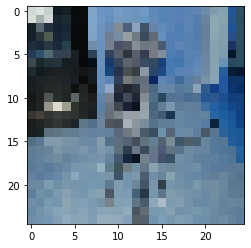

In [7]:
new_data_1 = resized_image_data(data[1], 25)
plt.imshow(new_data_1)

In [7]:
#The new array of image arrays

matrix = []
for i in range(len(data)):
  matrix.append(resized_image_data(data[i], 25))

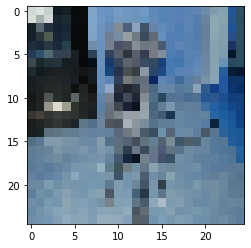

In [8]:
#A 25 * 25 RGB image!
matrix[1].shape, plt.imshow(matrix[1])
matrix = np.array(matrix) / 255

In [ ]:
data = np.array(data) / 255

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [1]:
matrix.shape, data.shape

NameError: ignored

(<matplotlib.image.AxesImage at 0x7facd9620710>, (332, 500, 3), (500, 400, 3))

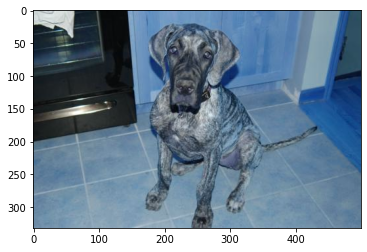

In [39]:

#OG for the 1 image, compare to the low-res image above!
plt.imshow(data[1]), data[1].shape, data[3].shape


The array 'data' will be the High resolution images and 'matrix' is low res. Below I will do a 'ghetto' train test split (the images are already initially sorted at random in the initial dataset, so all there is to do is simply truncate the aforementioned arrays).

In [58]:
#The train test split performed
print(len(matrix) * 0.8, len(matrix) * 0.2)

9976.0 2494.0


In [60]:
train_lr = matrix[0:9976] #9976.0 images
test_lr = matrix[9976: len(matrix)] #However many are left
train_hr = data[0:9976] #9976.0 images
test_hr = data[9976: len(data)] #However many are left

In [66]:
train_lr[1].shape

(25, 25, 3)

# New section

In [ ]:
import tensorflow
import tensorflow as tf 
from tensorflow.keras.layers import Dense,  Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten,LeakyReLU
from tensorflow.keras.layers import BatchNormalization,PReLU  , add
from tensorflow.keras.models import Sequential, Model



class Generator:
    def __init__(self):
        self.generator_model = None
        self.shared_axes = [1,2]
        self.no_resblocks = 16

    def residual_block(self, input):
        
        model = Sequential()

        model.add(Conv2D(64, (3,3), padding = "same")(input)) 
        model.add(BatchNormalization(momentum = 0.6)(model)) 
        model.add(PReLU(shared_axes = self.shared_axes)(model)) 
        model.add(Conv2D(64, (3,3), padding = "same")(model)) 
        model.add(BatchNormalization(momentum = 0.6)(model)) 
    
        return add([input,model])

    def B_block(self, input):

        model = Sequential()
        
        model.add(Conv2D(64, (3,3), padding = "same")(input)) 
        model.add(UpSampling2D( size = 2 )(model))(input) 
        model.add(PReLU(shared_axes=self.shared_axes)(model)) 
    
        return model
    
    def create_generator(self, generator_inputs):
        model = Sequential()
        model.add(Conv2D(64, (9,9), padding = "same"))  
        model.add(PReLU(shared_axes=self.shared_axes)(model))
        temp = model

        for i in range(0,self.no_resblocks): 
            model.add(PReLU(shared_axes=self.shared_axes)(model))

        model.add(Conv2D(64, (3,3), padding="same")(model))
        model.add(BatchNormalization(momentum=0.6)(model))
        model = add([model,temp])

        model.add(B_block(model))
        model.add(B_block(model))

        op = Conv2D(3, (9,9), padding="same")(model)

        return Model(inputs=generator_inputs, outputs=op)


class Discriminator:


    def discriminator_block(self, inputs, filters, strides=1, batchnorm=True):
        disc_model = Sequential()
        disc_model.add(Conv2D(filters, (3,3), strides = strides, padding="same")(inputs))
        disc_model.add(LeakyReLU( alpha=0.2 )(disc_model))
        if batchnorm:
            disc_model.add(BatchNormalization( momentum=0.6 )(disc_model))

        
        return disc_model



    def create_discriminator(self,disc_inputs):

        df = 64
        d = Sequential()
        d.add(discriminator_block(disc_inputs, df, batchnorm=False))
        d.add(discriminator_block(d, df, strides=2))
        d.add(discriminator_block(d, df*2))
        d.add(discriminator_block(d, df*2, strides=2))
        d.add(discriminator_block(d, df*4))
        d.add(discriminator_block(d, df*4, strides=2))
        d.add(discriminator_block(d, df*8))
        d.add(discriminator_block(d, df*8, strides=2))
        
        d8_5 = Flatten()(d)
        d8_5.add(Dense(df*16)(d8_5))
        d8_5.add(LeakyReLU(alpha=0.2)(d8_5))
        #Might want to experiment with different activation functions here for the output
        validity = Sequential()
        validity.add(Dense(1, activation='sigmoid')(d))

        return Model(disc_inputs, validity)

In [ ]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
lr_

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
#lr_shape = x_train.shape
#hr_shape = x_test.shape
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)  
#lr_ip = lr_ip[1][:50000]
#hr_ip = hr_ip[1][:10000]
lr_ip.shape, lr_ip

(TensorShape([50000, 32, 32, 3]),
 <KerasTensor: shape=(50000, 32, 32, 3) dtype=float32 (created by layer 'tf.__operators__.getitem_49')>)

In [ ]:
lr_ip 

<KerasTensor: shape=(50000, 32, 32, 3) dtype=float32 (created by layer 'tf.__operators__.getitem_49')>

In [ ]:
 
import os
import cv2
import numpy as np



import matplotlib.pyplot as plt
from keras import Model, layers
from keras.applications import VGG19
generator_object= Generator()
discriminator_object = Discriminator()
 


Input = layers.Input  
'''
data_gen = DataGenerator()
train_low_res_images, train_high_res_images = data_gen.get_training_data()
test_low_res_images, test_high_res_images = data_gen.get_testing_data()
'''

train_low_res_images = x_train
train_high_res_images = x_test
num_res_block = 16#generator_object.no_resblocks
high_res_shape = (train_high_res_images.shape[1], train_high_res_images.shape[2], train_high_res_images.shape[3])
low_res_shape = (train_low_res_images.shape[1], train_low_res_images.shape[2], train_low_res_images.shape[3])

#low_res_inputs = Input(shape=low_res_shape)
#high_res_inputs = Input(shape=high_res_shape)
low_res_inputs = lr_ip
high_res_inputs = hr_ip
#generator = generator_object.create_generator(low_res_inputs)
#discriminator = discriminator_object.create_disc(high_res_inputs)
generator = generator_object.create_generator(lr_ip)
discriminator = discriminator_object.create_discriminator(hr_ip)
discriminator.compile(loss = "binary_crossentropy", optimizer="adam", metrics=['accuracy'])

#Build vgg pretrained model weights
def build_vgg():
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]

    img = Input(shape=high_res_shape)

    i#mg_features = vgg(img)

    return Model(img, img_features)


vgg = build_vgg()
vgg.trainable = False

#Used to combine the Discriminator and Generator into GAN model

def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


gan_model = create_comb(generator, discriminator, vgg, low_res_inputs, high_res_inputs)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam") 



 

def train(batch_size, epochs):
    #epochs = 100
    train_low_res_images_batches = []
    train_high_res_images_batches = []
    for it in range(int(train_high_res_images.shape[0] / batch_size)):
        start_idx = it * batch_size
        end_idx = start_idx + batch_size
        train_high_res_images_batches.append(train_high_res_images[start_idx:end_idx])
        train_low_res_images_batches.append(train_low_res_images[start_idx:end_idx])

    for e in range(epochs):
        
        gen_label = np.zeros((batch_size, 1))
        real_label = np.ones((batch_size,1))
        g_losses = []
        d_losses = []
        for b in range(len(train_high_res_images_batches)):
            lr_imgs = train_low_res_images_batches[b]
            hr_imgs = train_high_res_images_batches[b]
            
            gen_imgs = generator.predict_on_batch(lr_imgs)
            
            discriminator.trainable = True
            d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
            d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
            discriminator.trainable = False
            
            d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
            
            image_features = vgg.predict(hr_imgs)

            
            g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            
        g_losses = np.array(g_losses)
        d_losses = np.array(d_losses)
        
        g_loss = np.sum(g_losses, axis=0) / len(g_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)
        
        print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
        

TypeError: ignored

In [ ]:
low_res_inputs.shape, lr_ip.shape

(TensorShape([None, 32, 32, 3]), TensorShape([None, 32, 32, 3]))

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

170500096/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [ ]:
lr_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
hr_shape = (x_test.shape[1], x_test.shape[2], x_test.shape[3])
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)
print(lr_shape, hr_shape)

(32, 32, 3) (32, 32, 3)


In [ ]:
#instantiate objects of classes
generator_object= Generator()
generator = generator_object.create_generator(lr_ip)

discriminator_object = Discriminator()
discriminator = discriminator_object.create_disc(hr_ip)

discriminator.compile(loss = "binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam") 





'''
generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False


gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam")
'''


NameError: ignored

In [ ]:
  gan_model.summary()

NameError: name 'gan_model' is not defined

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
print(x_train.shape)
print(x_train.shape[0])
print(x_test.shape[0])

print (y_test[0])
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print (y_test[0])

(50000, 32, 32, 3)
50000
10000
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


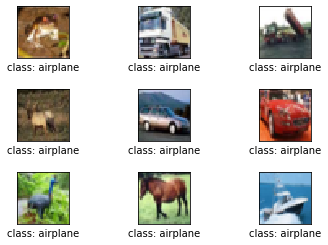

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])

    xlabel = "class: {0}".format(class_names[y_train[i].argmax()])

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])


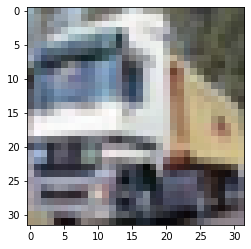

In [ ]:
plt.imshow(x_train[1])

In [ ]:
x_train[1].shape

(32, 32, 3)